## 1. Import Libraries

In [4]:
pip install lazypredict

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px

from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from lazypredict.Supervised import LazyClassifier
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 2. Load Dataset

In [6]:
df = pd.read_csv('churn_data_modeling.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [7]:
df.head()

Unnamed: 0                                id  \
0           0  24011ae4ebbe3035111d65fa7c15bc57   
1           1  d29c2c54acc38ff3c0614d0a653813dd   
2           2  764c75f661154dac3a6c254cd082ea7d   
3           3  bba03439a292a1e166f80264c16191cb   
4           4  149d57cf92fc41cf94415803a877cb4b   

                      channel_sales  cons_12m  cons_gas_12m  cons_last_month  \
0  foosdfpfkusacimwkcsosbicdxkicaua         0         54946                0   
1                           MISSING      4660             0                0   
2  foosdfpfkusacimwkcsosbicdxkicaua       544             0                0   
3  lmkebamcaaclubfxadlmueccxoimlema      1584             0                0   
4                           MISSING      4425             0              526   

  date_activ   date_end date_modif_prod date_renewal  ...  \
0 2013-06-15 2016-06-15      2015-11-01   2015-06-23  ...   
1 2009-08-21 2016-08-30      2009-08-21   2015-08-31  ...   
2 2010-04-16 2016-04-16      2010-04-16   2015-04-17  ...   
3 2010-03-30 2016-03-30      2010-03-30   2015-03-31  ...   
4 2010-01-13 2016-03-07      2010-01-13   2015-03-09  ...   

   mean_year_price_off_peak_var  mean_year_price_peak_var  \
0                          0.13                      0.09   
1                          0.15                      0.00   
2                          0.17                      0.09   
3                          0.15                      0.00   
4                          0.12                      0.10   

   mean_year_price_mid_peak_var  mean_year_price_off_peak_fix  \
0                          0.04                         42.50   
1                          0.00                         44.44   
2                          0.00                         44.44   
3                          0.00                         44.44   
4                          0.07                         40.73   

   mean_year_price_peak_fix  mean_year_price_mid_peak_fix  \
0                     12.22                          8.15   
1                      0.00                          0.00   
2                      0.00                          0.00   
3                      0.00                          0.00   
4                     24.44                         16.29   

   mean_year_price_off_peak mean_year_price_peak  mean_year_price_med_peak_y  \
0                     42.63                12.31                        8.18   
1                     44.59                 0.00                        0.00   
2                     44.61                 0.09                        0.00   
3                     44.59                 0.00                        0.00   
4                     40.85                24.54                       16.37   

   churn  
0      1  
1      0  
2      0  
3      0  
4      0  

[5 rows x 55 columns]

In [8]:
df.drop(columns="Unnamed: 0", axis=1, inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14605 entries, 0 to 14604
Data columns (total 54 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              14605 non-null  object        
 1   channel_sales                   14605 non-null  object        
 2   cons_12m                        14605 non-null  int64         
 3   cons_gas_12m                    14605 non-null  int64         
 4   cons_last_month                 14605 non-null  int64         
 5   date_activ                      14605 non-null  datetime64[ns]
 6   date_end                        14605 non-null  datetime64[ns]
 7   date_modif_prod                 14605 non-null  datetime64[ns]
 8   date_renewal                    14605 non-null  datetime64[ns]
 9   forecast_cons_12m               14605 non-null  float64       
 10  forecast_cons_year              14605 non-null  int64         
 11  fo

In [10]:
df.describe()

cons_12m  cons_gas_12m  cons_last_month  \
count   14605.00      14605.00         14605.00   
mean   159230.27      28091.08         16091.37   
min         0.00          0.00             0.00   
25%      5674.00          0.00             0.00   
50%     14116.00          0.00           793.00   
75%     40764.00          0.00          3383.00   
max   6207104.00    4154590.00        771203.00   
std    573483.63     162978.56         64366.26   

                          date_activ                       date_end  \
count                          14605                          14605   
mean   2011-01-28 06:33:35.802807040  2016-07-27 20:31:34.036289024   
min              2003-05-09 00:00:00            2016-01-28 00:00:00   
25%              2010-01-15 00:00:00            2016-04-27 00:00:00   
50%              2011-03-04 00:00:00            2016-08-01 00:00:00   
75%              2012-04-19 00:00:00            2016-10-31 00:00:00   
max              2014-09-01 00:00:00            2017-06-13 00:00:00   
std                              NaN                            NaN   

                     date_modif_prod                   date_renewal  \
count                          14605                          14605   
mean   2013-01-02 10:40:17.090037504  2015-07-21 07:07:24.916124672   
min              2003-05-09 00:00:00            2013-06-26 00:00:00   
25%              2010-08-12 00:00:00            2015-04-17 00:00:00   
50%              2013-06-18 00:00:00            2015-07-27 00:00:00   
75%              2015-06-16 00:00:00            2015-10-29 00:00:00   
max              2016-01-29 00:00:00            2016-01-28 00:00:00   
std                              NaN                            NaN   

       forecast_cons_12m  forecast_cons_year  forecast_discount_energy  ...  \
count           14605.00            14605.00                  14605.00  ...   
mean             1868.64             1399.86                      0.97  ...   
min                 0.00                0.00                      0.00  ...   
25%               494.98                0.00                      0.00  ...   
50%              1112.61              314.00                      0.00  ...   
75%              2402.27             1746.00                      0.00  ...   
max             82902.83           175375.00                     30.00  ...   
std              2387.65             3247.88                      5.11  ...   

       mean_year_price_off_peak_var  mean_year_price_peak_var  \
count                      14605.00                  14605.00   
mean                           0.14                      0.05   
min                            0.00                      0.00   
25%                            0.12                      0.00   
50%                            0.14                      0.08   
75%                            0.15                      0.10   
max                            0.28                      0.20   
std                            0.02                      0.05   

       mean_year_price_mid_peak_var  mean_year_price_off_peak_fix  \
count                      14605.00                      14605.00   
mean                           0.03                         43.06   
min                            0.00                          0.00   
25%                            0.00                         40.73   
50%                            0.00                         44.36   
75%                            0.07                         44.44   
max                            0.10                         59.44   
std                            0.04                          4.67   

       mean_year_price_peak_fix  mean_year_price_mid_peak_fix  \
count                  14605.00                      14605.00   
mean                       9.48                          6.12   
min                        0.00                          0.00   
25%                        0.00                          0.00   
50%                    

## 3. Feature Engineering

A. Difference between off-peak prices in December and preceding January

In [11]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

id price_date  price_off_peak_var  \
0  038af19179925da21a25619c5a24b745 2015-01-01                0.15   
1  038af19179925da21a25619c5a24b745 2015-02-01                0.15   
2  038af19179925da21a25619c5a24b745 2015-03-01                0.15   
3  038af19179925da21a25619c5a24b745 2015-04-01                0.15   
4  038af19179925da21a25619c5a24b745 2015-05-01                0.15   

   price_peak_var  price_mid_peak_var  price_off_peak_fix  price_peak_fix  \
0            0.00                0.00               44.27            0.00   
1            0.00                0.00               44.27            0.00   
2            0.00                0.00               44.27            0.00   
3            0.00                0.00               44.27            0.00   
4            0.00                0.00               44.27            0.00   

   price_mid_peak_fix  
0                0.00  
1                0.00  
2                0.00  
3                0.00  
4                0.00

In [12]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

id  offpeak_diff_dec_january_energy  \
0  0002203ffbb812588b632b9e628cc38d                            -0.01   
1  0004351ebdd665e6ee664792efc4fd13                            -0.00   
2  0010bcc39e42b3c2131ed2ce55246e3c                             0.05   
3  0010ee3855fdea87602a5b7aba8e42de                            -0.01   
4  00114d74e963e47177db89bc70108537                            -0.00   

   offpeak_diff_dec_january_power  
0                            0.16  
1                            0.18  
2                            1.50  
3                            0.16  
4                           -0.00

B. Merging both datasets

In [13]:
df = pd.merge(df, diff, on='id')
df.head()

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   
3  bba03439a292a1e166f80264c16191cb  lmkebamcaaclubfxadlmueccxoimlema   
4  149d57cf92fc41cf94415803a877cb4b                           MISSING   

   cons_12m  cons_gas_12m  cons_last_month date_activ   date_end  \
0         0         54946                0 2013-06-15 2016-06-15   
1      4660             0                0 2009-08-21 2016-08-30   
2       544             0                0 2010-04-16 2016-04-16   
3      1584             0                0 2010-03-30 2016-03-30   
4      4425             0              526 2010-01-13 2016-03-07   

  date_modif_prod date_renewal  forecast_cons_12m  ...  \
0      2015-11-01   2015-06-23               0.00  ...   
1      2009-08-21   2015-08-31             189.95  ...   
2      2010-04-16   2015-04-17              47.96  ...   
3      2010-03-30   2015-03-31             240.04  ...   
4      2010-01-13   2015-03-09             445.75  ...   

   mean_year_price_mid_peak_var  mean_year_price_off_peak_fix  \
0                          0.04                         42.50   
1                          0.00                         44.44   
2                          0.00                         44.44   
3                          0.00                         44.44   
4                          0.07                         40.73   

   mean_year_price_peak_fix  mean_year_price_mid_peak_fix  \
0                     12.22                          8.15   
1                      0.00                          0.00   
2                      0.00                          0.00   
3                      0.00                          0.00   
4                     24.44                         16.29   

   mean_year_price_off_peak  mean_year_price_peak mean_year_price_med_peak_y  \
0                     42.63                 12.31                       8.18   
1                     44.59                  0.00                       0.00   
2                     44.61                  0.09                       0.00   
3                     44.59                  0.00                       0.00   
4                     40.85                 24.54                      16.37   

   churn  offpeak_diff_dec_january_energy  offpeak_diff_dec_january_power  
0      1                             0.02                            3.70  
1      0                            -0.00                            0.18  
2      0                            -0.00                            0.18  
3      0                            -0.00                            0.18  
4      0                            -0.01                            0.16  

[5 rows x 56 columns]

C. Aggregate average prices per period by company and Calculate the mean difference between consecutive periods


In [14]:
mean_prices = price_df.groupby(['id']).agg({
    'price_off_peak_var': 'mean',
    'price_peak_var': 'mean',
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'
}).reset_index()

In [15]:
mean_prices['off_peak_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_peak_var']
mean_prices['peak_mid_peak_var_mean_diff'] = mean_prices['price_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_mid_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_peak_fix']
mean_prices['peak_mid_peak_fix_mean_diff'] = mean_prices['price_peak_fix'] - mean_prices['price_mid_peak_fix']
mean_prices['off_peak_mid_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']

In [16]:
columns = [
    'id',
    'off_peak_peak_var_mean_diff',
    'peak_mid_peak_var_mean_diff',
    'off_peak_mid_peak_var_mean_diff',
    'off_peak_peak_fix_mean_diff',
    'peak_mid_peak_fix_mean_diff',
    'off_peak_mid_peak_fix_mean_diff'
]
df = pd.merge(df, mean_prices[columns], on='id')
df.head()

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   
3  bba03439a292a1e166f80264c16191cb  lmkebamcaaclubfxadlmueccxoimlema   
4  149d57cf92fc41cf94415803a877cb4b                           MISSING   

   cons_12m  cons_gas_12m  cons_last_month date_activ   date_end  \
0         0         54946                0 2013-06-15 2016-06-15   
1      4660             0                0 2009-08-21 2016-08-30   
2       544             0                0 2010-04-16 2016-04-16   
3      1584             0                0 2010-03-30 2016-03-30   
4      4425             0              526 2010-01-13 2016-03-07   

  date_modif_prod date_renewal  forecast_cons_12m  ...  \
0      2015-11-01   2015-06-23               0.00  ...   
1      2009-08-21   2015-08-31             189.95  ...   
2      2010-04-16   2015-04-17              47.96  ...   
3      2010-03-30   2015-03-31             240.04  ...   
4      2010-01-13   2015-03-09             445.75  ...   

   mean_year_price_med_peak_y  churn  offpeak_diff_dec_january_energy  \
0                        8.18      1                             0.02   
1                        0.00      0                            -0.00   
2                        0.00      0                            -0.00   
3                        0.00      0                            -0.00   
4                       16.37      0                            -0.01   

   offpeak_diff_dec_january_power  off_peak_peak_var_mean_diff  \
0                            3.70                         0.02   
1                            0.18                         0.14   
2                            0.18                         0.08   
3                            0.18                         0.15   
4                            0.16                         0.02   

   peak_mid_peak_var_mean_diff off_peak_mid_peak_var_mean_diff  \
0                         0.03                            0.06   
1                         0.01                            0.15   
2                         0.09                            0.17   
3                         0.00                            0.15   
4                         0.03                            0.05   

   off_peak_peak_fix_mean_diff  peak_mid_peak_fix_mean_diff  \
0                        18.59                         7.45   
1                        44.31                         0.00   
2                        44.39                         0.00   
3                        44.40                         0.00   
4                        16.28                         8.14   

   off_peak_mid_peak_fix_mean_diff  
0                            26.04  
1                            44.31  
2                            44.39  
3                            44.40  
4                            24.41  

[5 rows x 62 columns]

In [17]:
mean_prices_by_month = price_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean',
    'price_peak_var': 'mean',
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'
}).reset_index()

In [18]:
mean_prices_by_month['off_peak_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_peak_var']
mean_prices_by_month['peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']

E. Calculate the maximum monthly difference across time periods

In [19]:
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'off_peak_peak_var_mean_diff': 'max',
    'peak_mid_peak_var_mean_diff': 'max',
    'off_peak_mid_peak_var_mean_diff': 'max',
    'off_peak_peak_fix_mean_diff': 'max',
    'peak_mid_peak_fix_mean_diff': 'max',
    'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
    columns={
        'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
        'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_mean_diff': 'off_peak_mid_peak_var_max_monthly_diff',
        'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
        'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_mean_diff': 'off_peak_mid_peak_fix_max_monthly_diff'
    }
)

In [39]:
columns = [
    'id',
    'off_peak_peak_var_max_monthly_diff',
    'peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_peak_fix_max_monthly_diff',
    'peak_mid_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]

df = pd.merge(df, max_diff_across_periods_months[columns], on='id')
df.head()

id  cons_12m  cons_gas_12m  cons_last_month  \
0  24011ae4ebbe3035111d65fa7c15bc57         0         54946                0   
1  d29c2c54acc38ff3c0614d0a653813dd      4660             0                0   
2  764c75f661154dac3a6c254cd082ea7d       544             0                0   
3  bba03439a292a1e166f80264c16191cb      1584             0                0   
4  149d57cf92fc41cf94415803a877cb4b      4425             0              526   

  date_activ   date_end date_modif_prod date_renewal  forecast_cons_12m  \
0 2013-06-15 2016-06-15      2015-11-01   2015-06-23               0.00   
1 2009-08-21 2016-08-30      2009-08-21   2015-08-31             189.95   
2 2010-04-16 2016-04-16      2010-04-16   2015-04-17              47.96   
3 2010-03-30 2016-03-30      2010-03-30   2015-03-31             240.04   
4 2010-01-13 2016-03-07      2010-01-13   2015-03-09             445.75   

   forecast_cons_year  ...  off_peak_mid_peak_var_max_monthly_diff_y  \
0                   0  ...                                      0.15   
1                   0  ...                                      0.15   
2                   0  ...                                      0.17   
3                   0  ...                                      0.15   
4                 526  ...                                      0.06   

   off_peak_peak_fix_max_monthly_diff_y  peak_mid_peak_fix_max_monthly_diff_y  \
0                                 44.27                                  8.15   
1                                 44.44                                  0.00   
2                                 44.44                                  0.00   
3                                 44.44                                  0.00   
4                                 16.29                                  8.15   

   off_peak_mid_peak_fix_max_monthly_diff_y  \
0                                     44.27   
1                                     44.44   
2                                     44.44   
3                                     44.44   
4                                     24.44   

   off_peak_peak_var_max_monthly_diff  peak_mid_peak_var_max_monthly_diff  \
0                                0.06                                0.09   
1                                0.15                                0.09   
2                                0.08                                0.09   
3                                0.15                                0.00   
4                                0.02                                0.03   

   off_peak_mid_peak_var_max_monthly_diff  off_peak_peak_fix_max_monthly_diff  \
0                                    0.15                               44.27   
1                                    0.15                               44.44   
2                                    0.17                               44.44   
3                                    0.15                               44.44   
4                                    0.06                               16.29   

   peak_mid_peak_fix_max_monthly_diff  off_peak_mid_peak_fix_max_monthly_diff  
0                                8.15                                   44.27  
1                                0.00                                   44.44  
2                                0.00                                   44.44  
3                                0.00                                   44.44  
4                                8.15                                   24.44  

[5 rows x 91 columns]

## 4. Tenure

How long a company has been a client of PoweCo

In [21]:
df['tenure'] = ((df['date_end'] - df['date_activ'])/ np.timedelta64(1, 'Y')).astype(int)
df.groupby(['tenure']).agg({'churn': 'mean'}).sort_values(by='churn', ascending=False)

churn
tenure       
2        0.18
3        0.14
4        0.13
13       0.10
5        0.09
12       0.08
7        0.08
6        0.08
11       0.06
8        0.05
10       0.05
9        0.01

Companies who have been client only for 4 months or less than 4 months are more likely to churn compared to other clients

## 5. Transforming Dates into Months

In [22]:
def convert_months(reference_date, df, column):
    """
    Input a column with timedeltas and return months
    """
    time_delta = reference_date - df[column]
    months = (time_delta / np.timedelta64(1, 'M')).astype(int)
    return months

In [23]:
# Create reference date
reference_date = datetime(2016, 1, 1)

# Create columns
df['months_activ'] = convert_months(reference_date, df, 'date_activ')
df['months_to_end'] = -convert_months(reference_date, df, 'date_end')
df['months_modif_prod'] = convert_months(reference_date, df, 'date_modif_prod')
df['months_renewal'] = convert_months(reference_date, df, 'date_renewal')

In [ ]:
# We no longer need the datetime columns that we used for feature engineering, so we can drop them
remove = [
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'
]

df = df.drop(columns=remove)
df.head()

## 6. Transforming the Boolean Data

In [24]:
df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0])
df.groupby(['has_gas']).agg({'churn': 'mean'})

churn
has_gas       
0         0.10
1         0.08

Customers who bought multiple products from company are sure clients and are loyal towards company whose churn rates are lows

In [41]:
# Transform into categorical type
df['channel_sales'] = df['channel_sales'].astype('category')

# Let's see how many categories are within this column
df['channel_sales'].value_counts()

KeyError: 'channel_sales'

In [ ]:
df = pd.get_dummies(df, columns=['channel_sales'], prefix='channel')
df = df.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
df.head()

In [42]:
# Transform into categorical type
df['origin_up'] = df['origin_up'].astype('category')

# Let's see how many categories are within this column
df['origin_up'].value_counts()

KeyError: 'origin_up'

In [ ]:
df = pd.get_dummies(df, columns=['origin_up'], prefix='origin_up')
df = df.drop(columns=['origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
df.head()

In [45]:
skewed = [
    'cons_12m',
    'cons_gas_12m',
    'cons_last_month',
    'forecast_cons_12m',
    'forecast_cons_year',
    'forecast_discount_energy',
    'forecast_meter_rent_12m',
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak',
    'forecast_price_pow_off_peak'
]

df[skewed].describe()

cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
count   14605.00      14605.00         14605.00           14605.00   
mean   159230.27      28091.08         16091.37            1868.64   
std    573483.63     162978.56         64366.26            2387.65   
min         0.00          0.00             0.00               0.00   
25%      5674.00          0.00             0.00             494.98   
50%     14116.00          0.00           793.00            1112.61   
75%     40764.00          0.00          3383.00            2402.27   
max   6207104.00    4154590.00        771203.00           82902.83   

       forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
count            14605.00                  14605.00                 14605.00   
mean              1399.86                      0.97                    63.09   
std               3247.88                      5.11                    66.17   
min                  0.00                      0.00                     0.00   
25%                  0.00                      0.00                    16.18   
50%                314.00                      0.00                    18.80   
75%               1746.00                      0.00                   131.03   
max             175375.00                     30.00                   599.31   

       forecast_price_energy_off_peak  forecast_price_energy_peak  \
count                        14605.00                    14605.00   
mean                             0.14                        0.05   
std                              0.02                        0.05   
min                              0.00                        0.00   
25%                              0.12                        0.00   
50%                              0.14                        0.08   
75%                              0.15                        0.10   
max                              0.27                        0.20   

       forecast_price_pow_off_peak  
count                     14605.00  
mean                         43.13  
std                           4.49  
min                           0.00  
25%                          40.61  
50%                          44.31  
75%                          44.31  
max                          59.27

## A. Applying log10 Transformation

In [46]:
df["cons_12m"] = np.log10(df["cons_12m"] + 1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"] + 1)
df["cons_last_month"] = np.log10(df["cons_last_month"] + 1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"] + 1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"] + 1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"] + 1)
df["imp_cons"] = np.log10(df["imp_cons"] + 1)

In [47]:
df[skewed].describe()

cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
count  14605.00      14605.00         14605.00           14605.00   
mean       4.22          0.78             2.26               2.96   
std        0.88          1.72             1.77               0.68   
min        0.00          0.00             0.00               0.00   
25%        3.75          0.00             0.00               2.70   
50%        4.15          0.00             2.90               3.05   
75%        4.61          0.00             3.53               3.38   
max        6.79          6.62             5.89               4.92   

       forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
count            14605.00                  14605.00                 14605.00   
mean                 1.78                      0.97                     1.52   
std                  1.58                      5.11                     0.57   
min                  0.00                      0.00                     0.00   
25%                  0.00                      0.00                     1.24   
50%                  2.50                      0.00                     1.30   
75%                  3.24                      0.00                     2.12   
max                  5.24                     30.00                     2.78   

       forecast_price_energy_off_peak  forecast_price_energy_peak  \
count                        14605.00                    14605.00   
mean                             0.14                        0.05   
std                              0.02                        0.05   
min                              0.00                        0.00   
25%                              0.12                        0.00   
50%                              0.14                        0.08   
75%                              0.15                        0.10   
max                              0.27                        0.20   

       forecast_price_pow_off_peak  
count                     14605.00  
mean                         43.13  
std                           4.49  
min                           0.00  
25%                          40.61  
50%                          44.31  
75%                          44.31  
max                          59.27

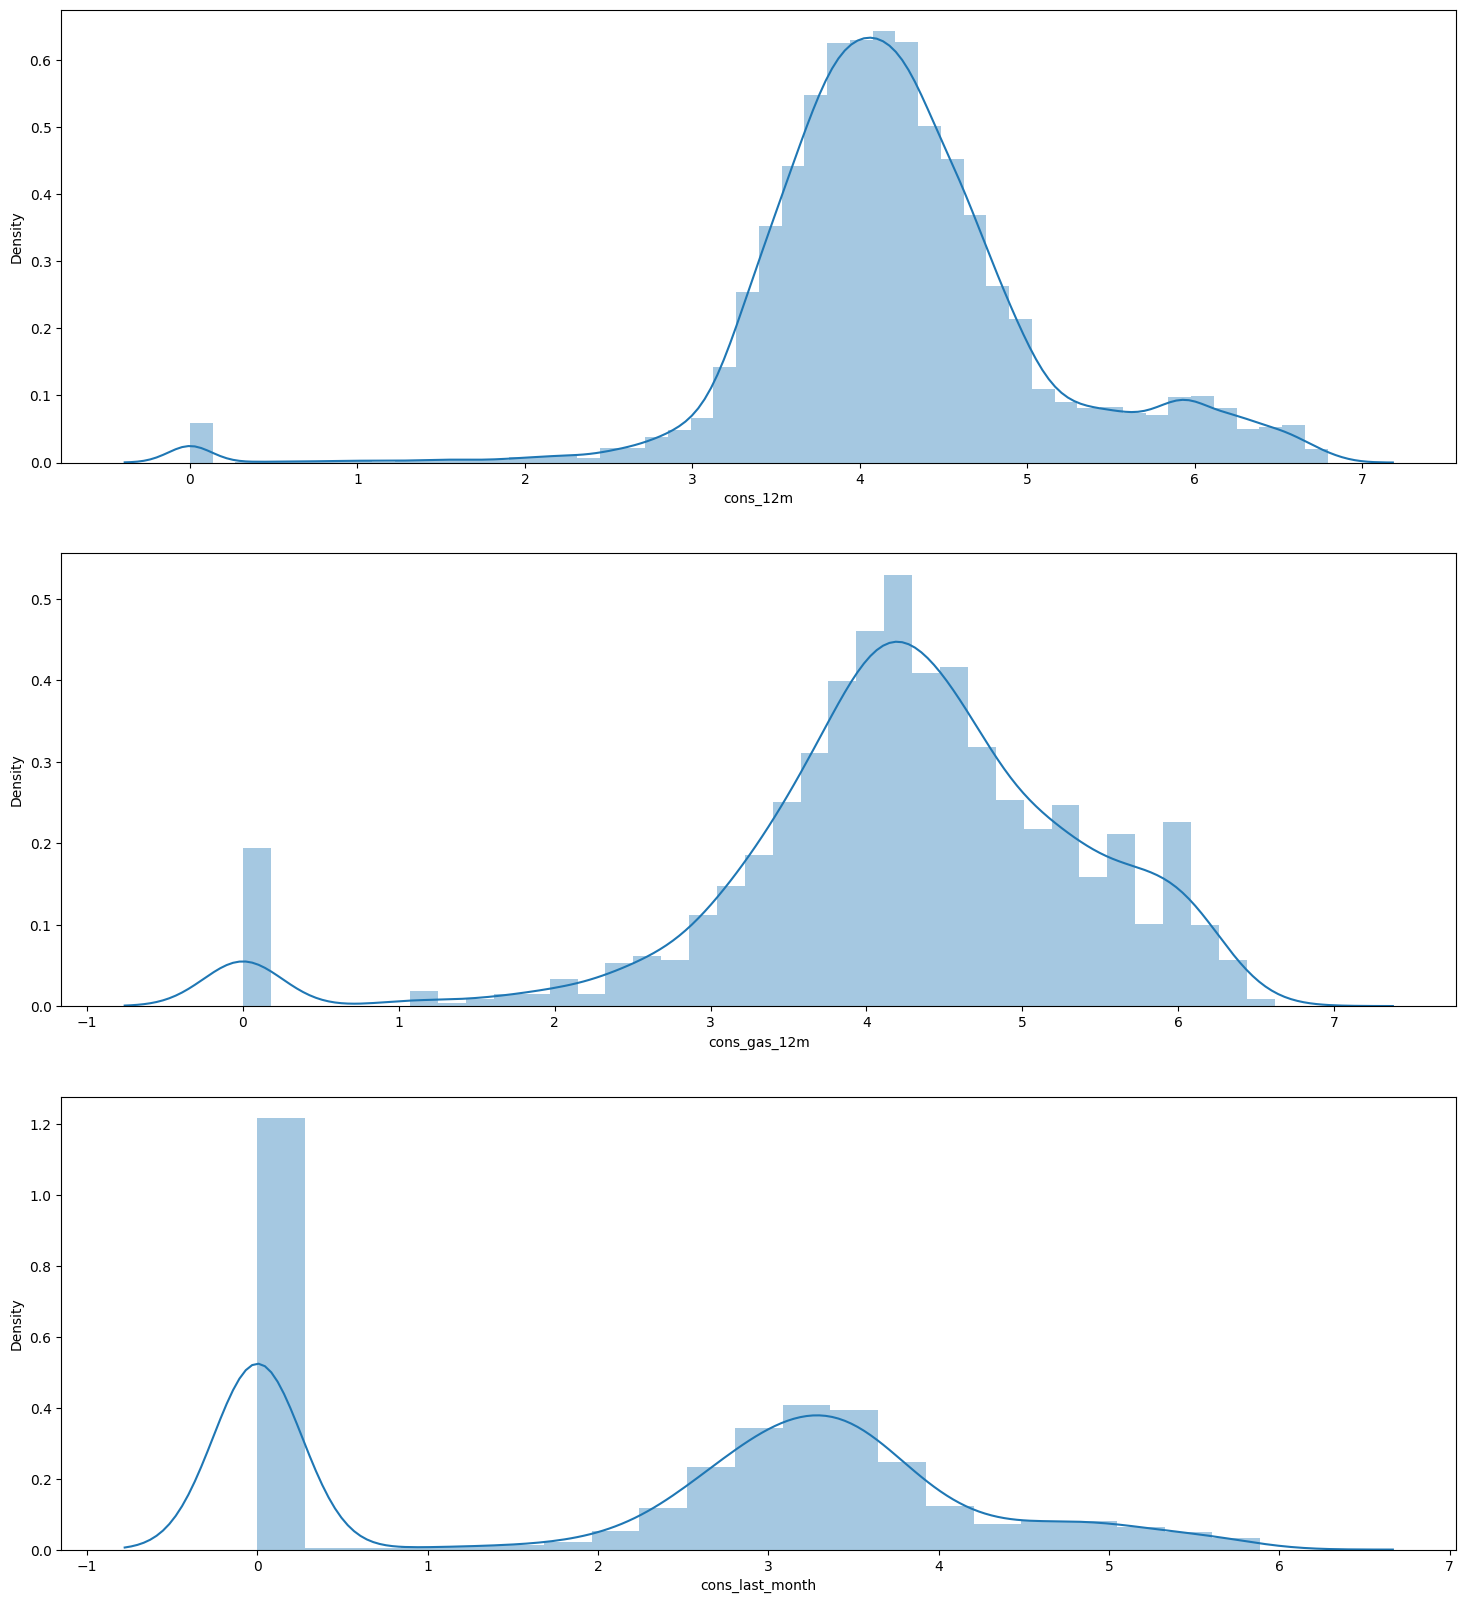

In [48]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 20))
# Plot histograms
sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.distplot((df["cons_last_month"].dropna()), ax=axs[2])
plt.show()

## 9. Corrlelation

**Importance of Linear Relationships:** Understanding the linear relationships between features is crucial for predictive modeling, particularly in the context of predicting churn.

**Correlation with Churn:** The goal is to identify features that correlate with churn, indicating their potential as predictors for the target variable. High correlation suggests that these features may be informative for predicting customer churn.

**Caution with High Correlation:** However, a very high correlation between features might raise suspicion. High correlation implies that these features share similar information, which can be problematic for predictive models.

**Independence Assumption:** Parametric predictive models assume feature independence. If two features are highly correlated, it violates the assumption that each feature should be independent of others. This is a key consideration for building reliable predictive models.

**Ideal Scenario:** Ideally, the desired set of features should exhibit zero correlation with independent variables (all features except the target variable) and high correlation with the target variable (churn). Achieving this ideal scenario is rare, and there's often a small degree of correlation among independent features.

**Balancing Act:** The challenge lies in striking a balance between having features that contribute independently to the model while ensuring they are still informative for predicting the target variable, in this case, customer churn. Managing correlations appropriately is essential for building robust and accurate predictive models.

In [50]:
# Convert columns with string values to numerical values
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, replace non-convertible values with NaN
        except:
            print(f"Could not convert column {col}")

# Calculate the correlation matrix
corr = df.corr()

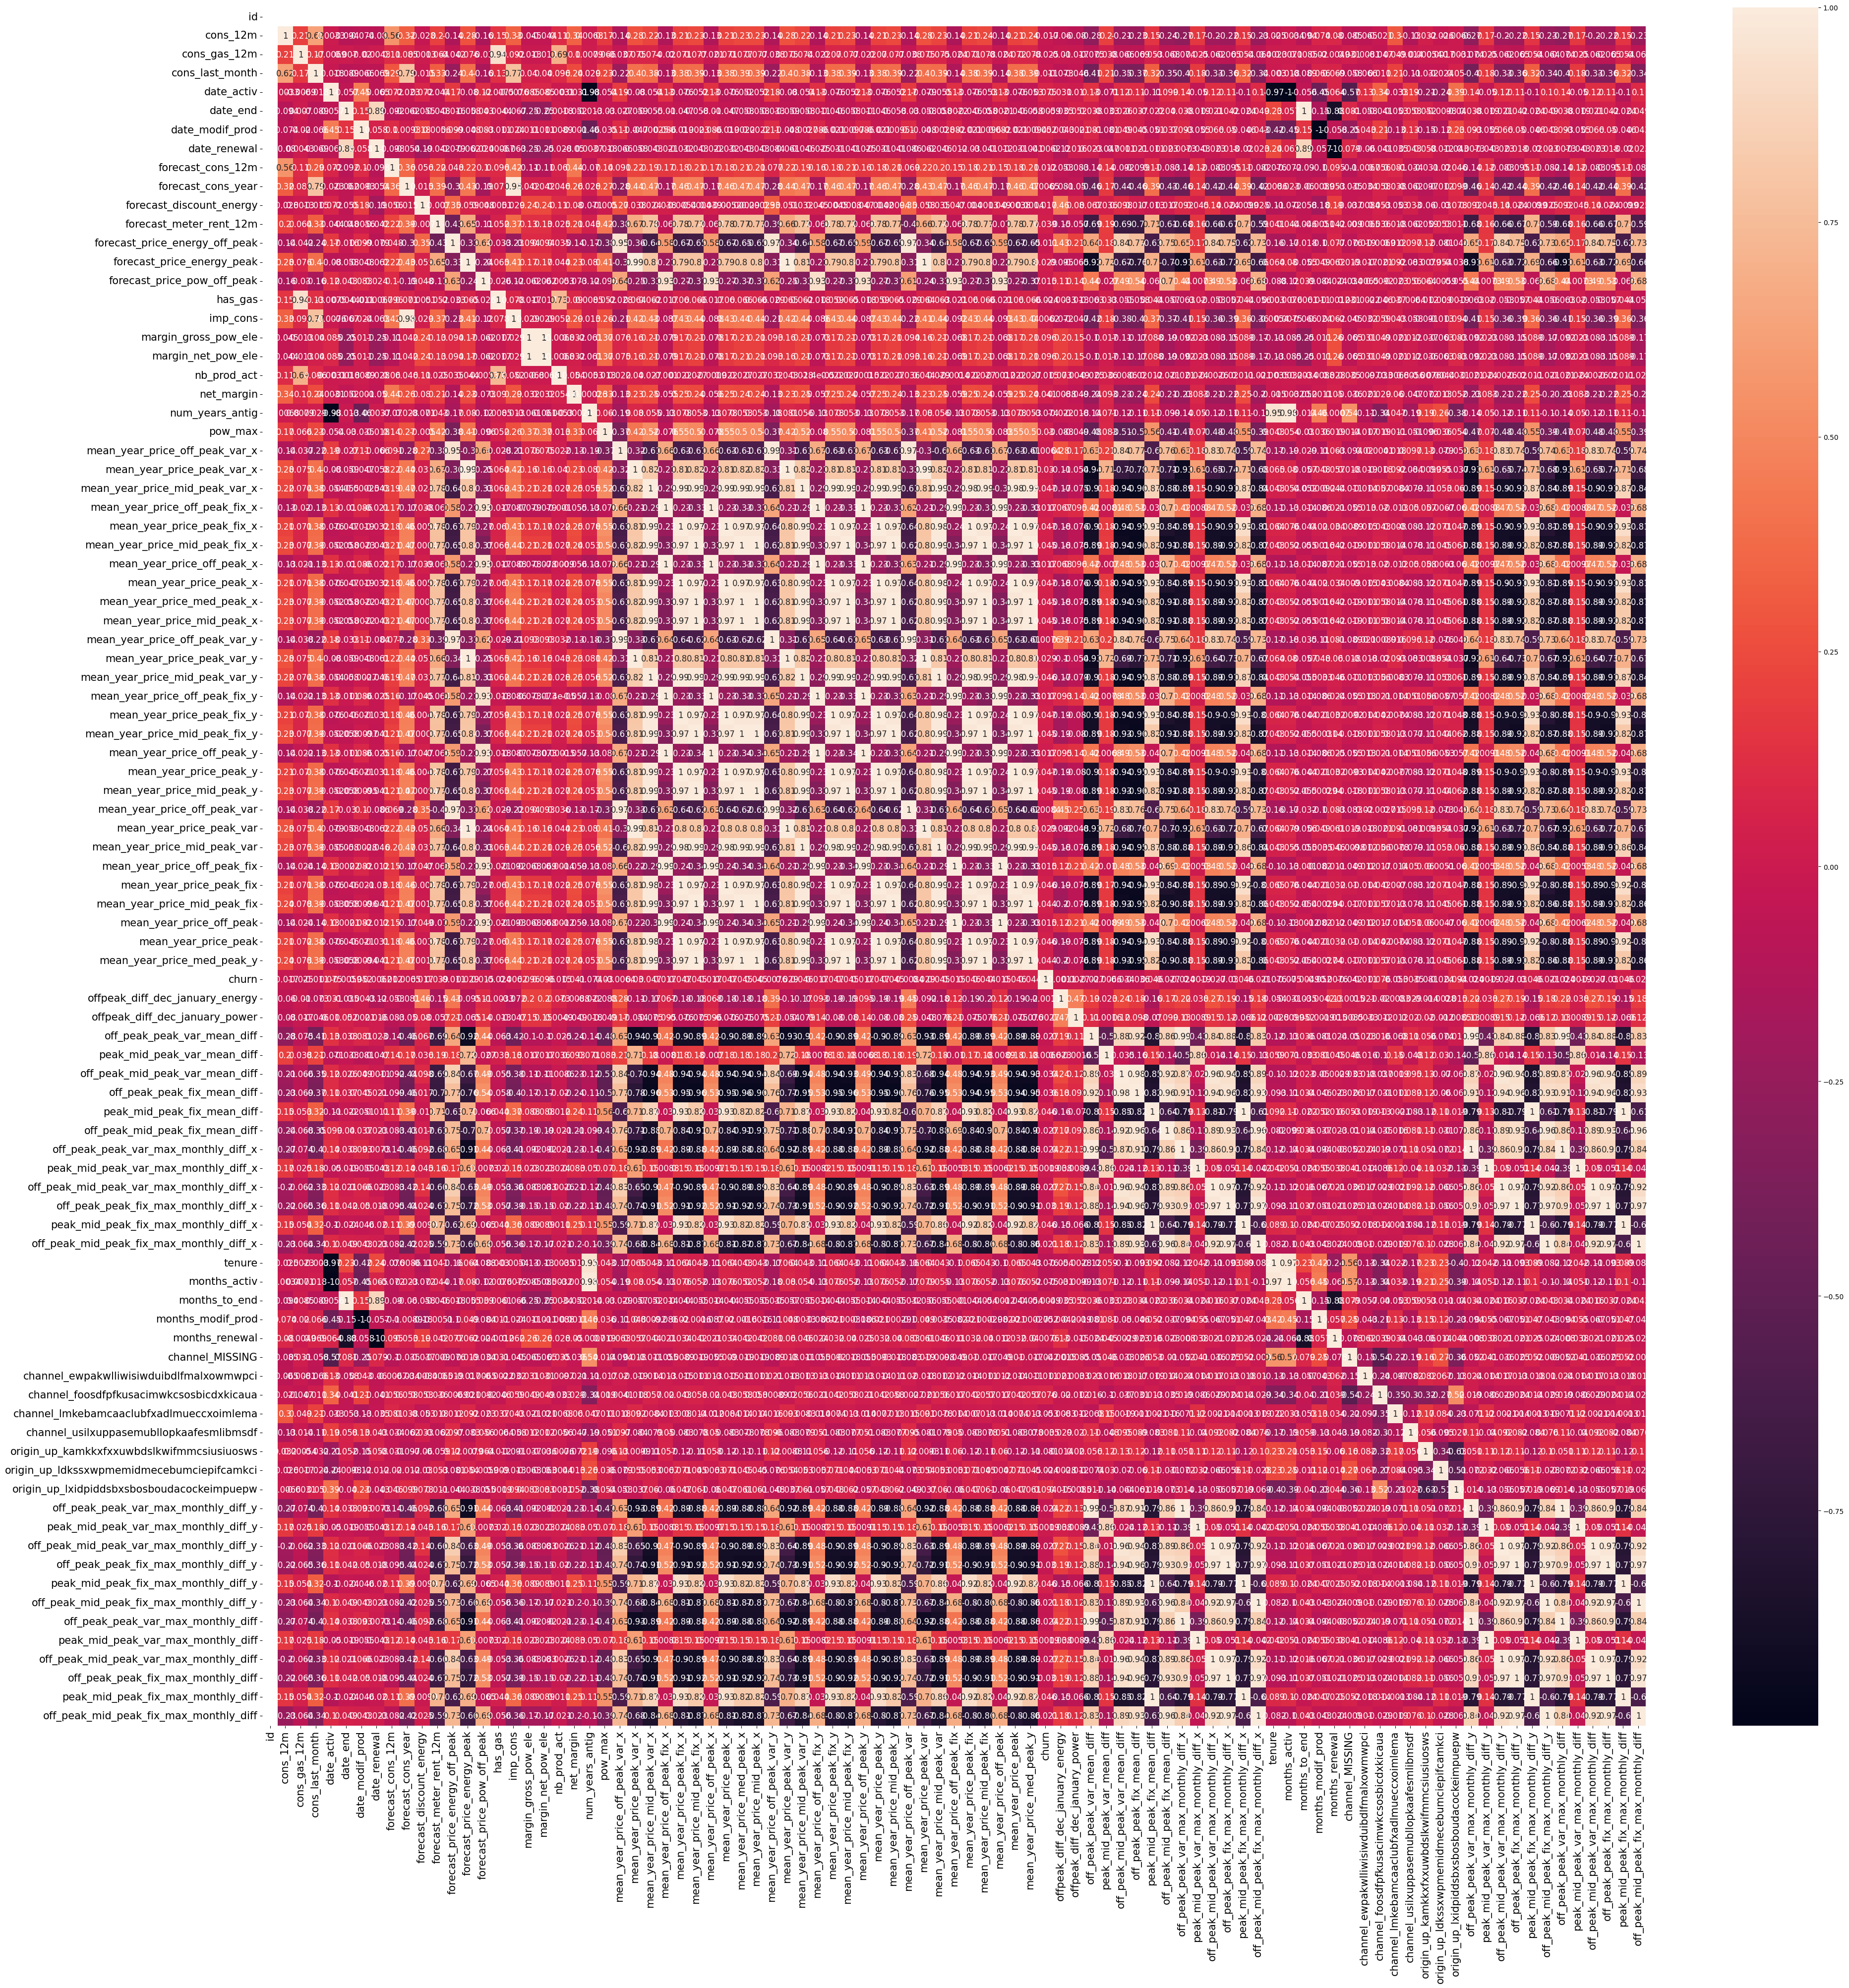

In [51]:
# Plot correlation
plt.figure(figsize=(45, 45))
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    annot=True,
    annot_kws={'size': 12}
)
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [52]:
fig = px.imshow(corr, aspect="auto")
fig.update_layout(width=1000, height=1000)
fig.show()

In [53]:
df = df.drop(columns=['num_years_antig', 'forecast_cons_year'])
df.head()

id  cons_12m  cons_gas_12m  cons_last_month date_activ   date_end  \
0 NaN      0.00          4.74             0.00 2013-06-15 2016-06-15   
1 NaN      3.67          0.00             0.00 2009-08-21 2016-08-30   
2 NaN      2.74          0.00             0.00 2010-04-16 2016-04-16   
3 NaN      3.20          0.00             0.00 2010-03-30 2016-03-30   
4 NaN      3.65          0.00             2.72 2010-01-13 2016-03-07   

  date_modif_prod date_renewal  forecast_cons_12m  forecast_discount_energy  \
0      2015-11-01   2015-06-23               0.00                      0.00   
1      2009-08-21   2015-08-31               2.28                      0.00   
2      2010-04-16   2015-04-17               1.69                      0.00   
3      2010-03-30   2015-03-31               2.38                      0.00   
4      2010-01-13   2015-03-09               2.65                      0.00   

   ...  off_peak_mid_peak_var_max_monthly_diff_y  \
0  ...                                      0.15   
1  ...                                      0.15   
2  ...                                      0.17   
3  ...                                      0.15   
4  ...                                      0.06   

   off_peak_peak_fix_max_monthly_diff_y  peak_mid_peak_fix_max_monthly_diff_y  \
0                                 44.27                                  8.15   
1                                 44.44                                  0.00   
2                                 44.44                                  0.00   
3                                 44.44                                  0.00   
4                                 16.29                                  8.15   

   off_peak_mid_peak_fix_max_monthly_diff_y  \
0                                     44.27   
1                                     44.44   
2                                     44.44   
3                                     44.44   
4                                     24.44   

   off_peak_peak_var_max_monthly_diff  peak_mid_peak_var_max_monthly_diff  \
0                                0.06                                0.09   
1                                0.15                                0.09   
2                                0.08                                0.09   
3                                0.15                                0.00   
4                                0.02                                0.03   

   off_peak_mid_peak_var_max_monthly_diff  off_peak_peak_fix_max_monthly_diff  \
0                                    0.15                               44.27   
1                                    0.15                               44.44   
2                                    0.17                               44.44   
3                                    0.15                               44.44   
4                                    0.06                               16.29   

   peak_mid_peak_fix_max_monthly_diff  off_peak_mid_peak_fix_max_monthly_diff  
0                                8.15                                   44.27  
1                                0.00                                   44.44  
2                                0.00                                   44.44  
3                                0.00                                   44.44  
4                                8.15                                   24.44  

[5 rows x 89 columns]

## 10. Modelling

A. Splitting Data into Training and Testing Sets

In [54]:
# Make a copy of our data
train_df = df.copy()

# Separate target variable from independent variables
y = df['churn']
X = df.drop(columns=['id', 'churn'])
print(X.shape)
print(y.shape)

(14605, 87)
(14605,)


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10953, 87)
(10953,)
(3652, 87)
(3652,)


B. Model Training

In [63]:
model = RandomForestClassifier(
    n_estimators=1000
)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [57]:
# Make a copy of our data
train_df = df.copy()

# Separate target variable from independent variables
y = df['churn']
X = df.drop(columns=['id', 'churn'])

# Convert datetime columns to numerical features (e.g., Unix timestamp)
for col in X.select_dtypes(include=['datetime64']):
    X[col] = (X[col] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')  # Convert to Unix timestamp

print(X.shape)
print(y.shape)

(14605, 87)
(14605,)


C. Model Evaluation

In [64]:
predictions = model.predict(X_test)

In [65]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()

In [66]:
y_test.value_counts()

churn
0    3279
1     373
Name: count, dtype: int64

In [67]:
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

print(f"Accuracy: {metrics.accuracy_score(y_test, predictions)}")
print(f"Precision: {metrics.precision_score(y_test, predictions)}")
print(f"Recall: {metrics.recall_score(y_test, predictions)}")

True positives: 24
False positives: 2
True negatives: 3277
False negatives: 349

Accuracy: 0.9038882803943045
Precision: 0.9230769230769231
Recall: 0.064343163538874


11. Modelling using LazyPredict Supervised Learning Models

In [68]:
lazy_classify = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

In [69]:
models, predictions = lazy_classify.fit(X_train, X_test, y_train, y_test)

 97%|█████████▋| 28/29 [01:26<00:02,  2.51s/it]

[LightGBM] [Info] Number of positive: 1046, number of negative: 9907
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13574
[LightGBM] [Info] Number of data points in the train set: 10953, number of used features: 79
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.095499 -> initscore=-2.248268
[LightGBM] [Info] Start training from score -2.248268


100%|██████████| 29/29 [01:27<00:00,  3.02s/it]


In [70]:
print(models)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
XGBClassifier                      0.91               0.57     0.57      0.88   
DecisionTreeClassifier             0.83               0.56     0.56      0.83   
GaussianNB                         0.64               0.55     0.55      0.71   
LGBMClassifier                     0.91               0.55     0.55      0.87   
BernoulliNB                        0.62               0.55     0.55      0.70   
NearestCentroid                    0.62               0.55     0.55      0.69   
PassiveAggressiveClassifier        0.84               0.54     0.54      0.84   
LabelSpreading                     0.85               0.54     0.54      0.84   
ExtraTreeClassifier                0.83               0.54     0.54      0.83   
LabelPropagation                   0.85               0.54     0.54      0.84   
ExtraTreesClassifier        

In [71]:
model_2 = lgb.LGBMClassifier()
model_2.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1046, number of negative: 9907
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13365
[LightGBM] [Info] Number of data points in the train set: 10953, number of used features: 87
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.095499 -> initscore=-2.248268
[LightGBM] [Info] Start training from score -2.248268


LGBMClassifier()

In [74]:
y_pred_2 = model_2.predict(X_test)

In [75]:
print("Accuracy:", accuracy_score(y_test, y_pred_2))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_2))
print("Classification Report:\n", classification_report(y_test, y_pred_2))

Accuracy: 0.9071741511500547
Confusion Matrix:
 [[3274    5]
 [ 334   39]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95      3279
           1       0.89      0.10      0.19       373

    accuracy                           0.91      3652
   macro avg       0.90      0.55      0.57      3652
weighted avg       0.91      0.91      0.87      3652



In [76]:
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()

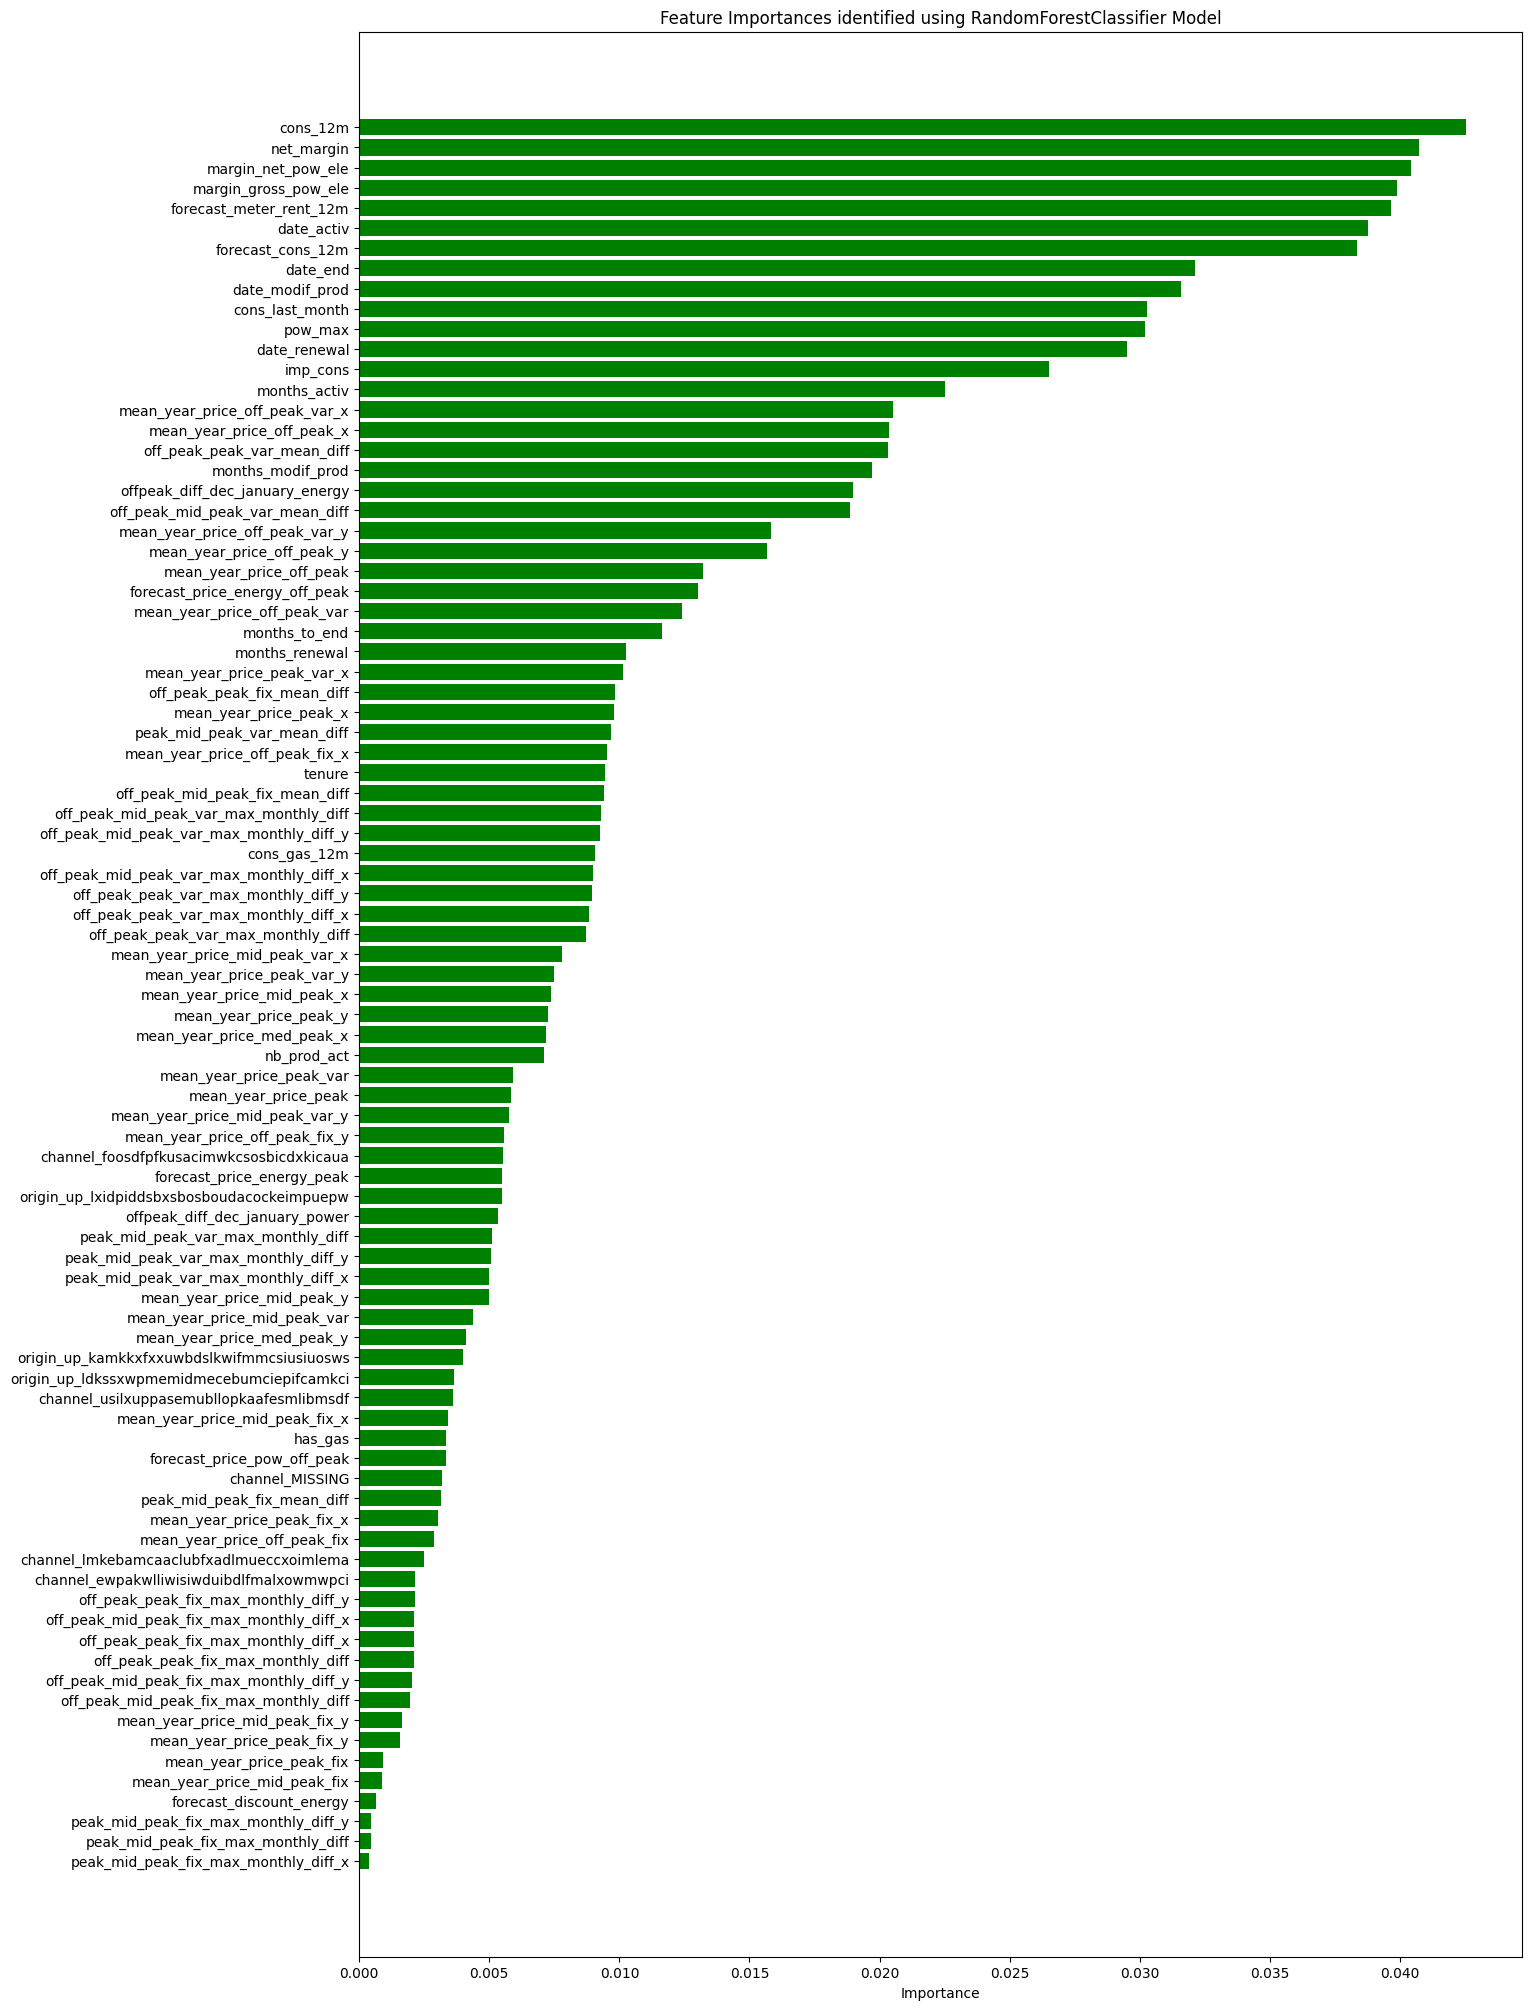

In [78]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances identified using RandomForestClassifier Model')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='g', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()

In [79]:
feature_importances_2 = pd.DataFrame({
    'features': X_train.columns,
    'importance': model_2.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()

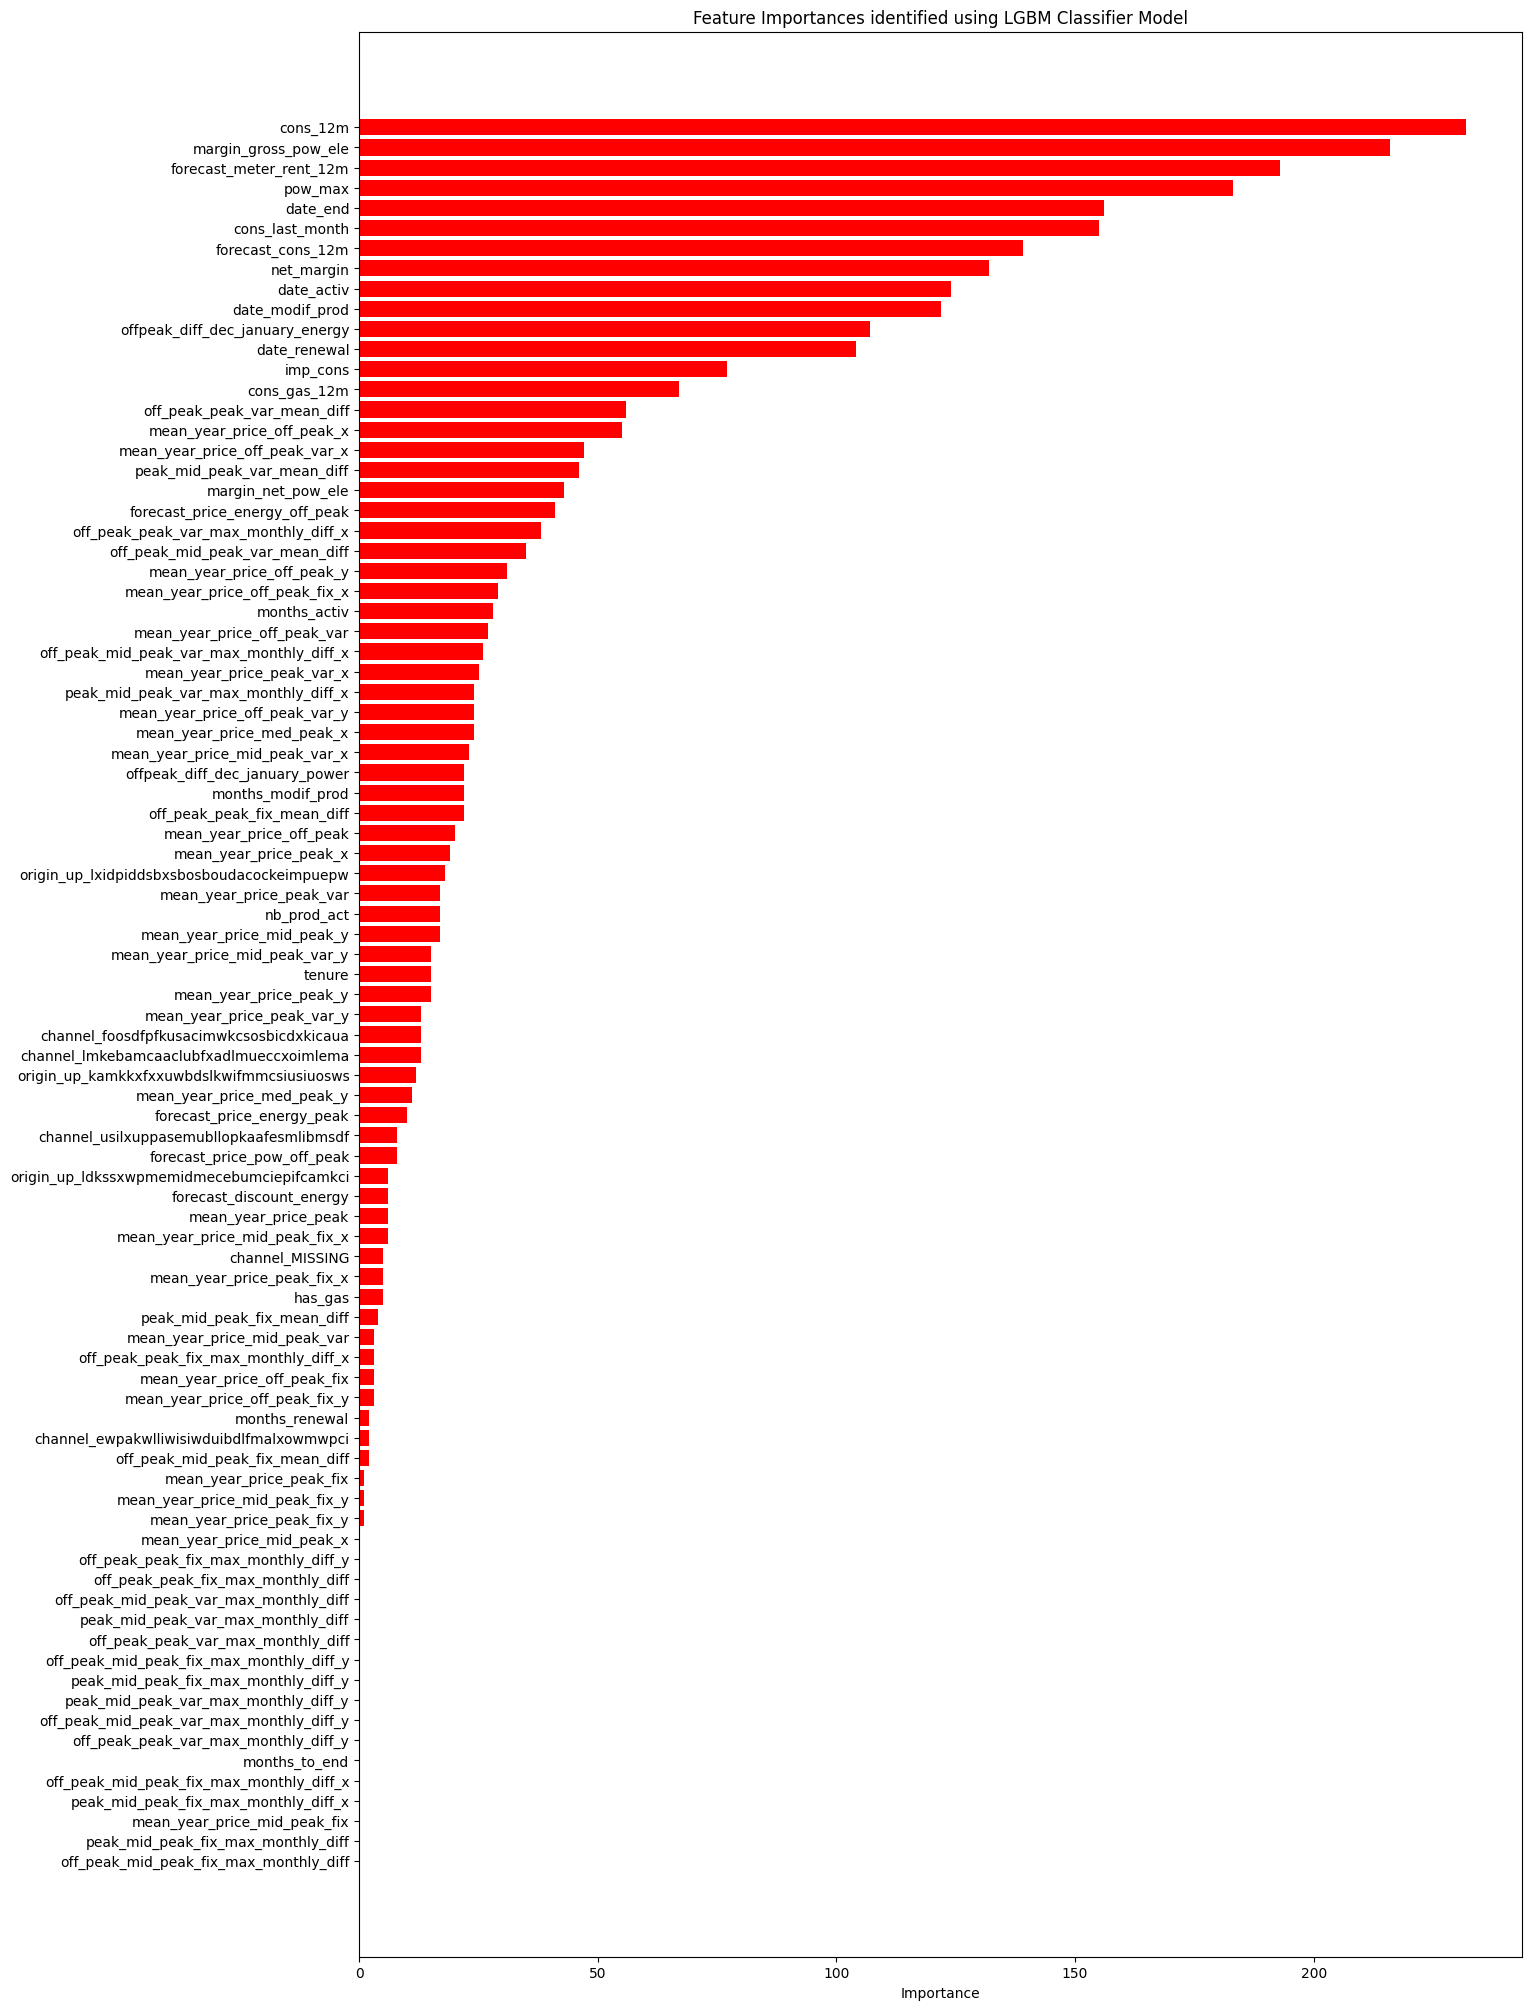

In [81]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances identified using LGBM Classifier Model')
plt.barh(range(len(feature_importances_2)), feature_importances_2['importance'], color='red', align='center')
plt.yticks(range(len(feature_importances_2)), feature_importances_2['features'])
plt.xlabel('Importance')
plt.show()

From both the above plots we can infer that the chrun highly depends on the 'cons_12m' parameter. But other parameters must also be considered